In [19]:
import csv
from collections import OrderedDict

import numpy as np
import matplotlib as mpl
import proplot as plt

In [ ]:
plt.use_style(["seaborn-dark-palette"])
plt.rc["text.usetex"] = True
plt.rc["text.latex.preamble"] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{cmbright}"
plt.rc["legend.facecolor"] = "white"
plt.rc["lines.linewidth"] = 0.75 
plt.rc["lines.markersize"] = 2
# Ticks
plt.rc["xtick.direction"] = "in"
plt.rc["ytick.direction"] = "in"

plt.rc["xtick.top"] = False
plt.rc["ytick.right"] = False

plt.rc["xtick.major.pad"] = 5
plt.rc["ytick.major.pad"] = 5

plt.rc["xtick.major.size"] = 3
plt.rc["xtick.minor.size"] = 2
plt.rc["xtick.minor.visible"] = False

plt.rc["ytick.major.size"] = 3
plt.rc["ytick.minor.size"] = 2
plt.rc["ytick.minor.visible"] = False

plt.rc["xtick.major.width"] = 0.5
plt.rc["xtick.minor.width"] = 0.3

plt.rc["ytick.major.width"] = 0.5
plt.rc["ytick.minor.width"] = 0.3

plt.rc["axes.linewidth"] = 0.6
plt.rc["axes.formatter.limits"] = -3, 4
plt.rc["axes.formatter.use_mathtext"] = True
plt.rc["axes3d.grid"] = False

## Plots

In [30]:
full_val_losses = OrderedDict()
with open('out/full_val_loss.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    header = next(reader)
    for name in header:
        full_val_losses[name] = []
    for row in reader:
        for val, name in zip(row, full_val_losses.keys()):
            if name.endswith("MIN") or name.endswith("MAX"):
                continue
            full_val_losses[name].append(float(val))

compact_val_losses = OrderedDict()
with open('out/compact_val_loss.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    header = next(reader)
    for name in header:
        compact_val_losses[name] = []
    for row in reader:
        for val, name in zip(row, compact_val_losses.keys()):
            # print(val, name)
            if name.endswith("MIN") or name.endswith("MAX"):
                continue
            compact_val_losses[name].append(float(val))


keys_to_delete = []
for key in full_val_losses.keys():
    if "MIN" in key or "MAX" in key:
        keys_to_delete.append(key)

for key in keys_to_delete:
    del full_val_losses[key]

keys_to_delete = []
for key in compact_val_losses.keys():
    if "MIN" in key or "MAX" in key:
        keys_to_delete.append(key)

for key in keys_to_delete:
    del compact_val_losses[key]


compact_items_to_sort = list(compact_val_losses.items())
compact_val_losses_sorted_items = sorted(
    compact_items_to_sort,
    key=lambda item: item[1][-1] if item[1] else float('-inf'),
    reverse=True
)
compact_val_losses = OrderedDict(compact_val_losses_sorted_items)


ordered_keys_from_compact = list(compact_val_losses.keys())
desired_key_order_for_full = []
for compact_key in ordered_keys_from_compact:
    if compact_key.startswith("compact - "):
        full_key = compact_key.replace("compact - ", "full - ", 1)
        desired_key_order_for_full.append(full_key)
    else:
        desired_key_order_for_full.append(compact_key)

new_full_val_losses = OrderedDict()
for full_key_in_desired_order in desired_key_order_for_full:
    if full_key_in_desired_order in full_val_losses:
        new_full_val_losses[full_key_in_desired_order] = full_val_losses[full_key_in_desired_order]

for original_full_key, original_full_value in full_val_losses.items():
    if original_full_key not in new_full_val_losses:
        new_full_val_losses[original_full_key] = original_full_value
        
full_val_losses = new_full_val_losses

def calculate_adaptive_moving_average(data_list, window_size):
    if not data_list:
        return []
    
    output_list = np.empty(len(data_list), dtype=float)
    for i in range(len(data_list)):
        current_window_actual_size = min(i + 1, window_size)
        start_index = i - current_window_actual_size + 1
        window = data_list[start_index : i + 1]
        output_list[i] = np.mean(window)
    return list(output_list)

WINDOW_SIZE = 8

for key in full_val_losses.keys():
    if isinstance(full_val_losses[key], list) and full_val_losses[key]:
        full_val_losses[key] = calculate_adaptive_moving_average(full_val_losses[key], WINDOW_SIZE)

for key in compact_val_losses.keys():
    if isinstance(compact_val_losses[key], list) and compact_val_losses[key]:
        compact_val_losses[key] = calculate_adaptive_moving_average(compact_val_losses[key], WINDOW_SIZE)


In [31]:
key_nf_val = 'full - no_features - val/loss'
key_ln_val = 'full - layer_norm - val/loss'
key_rope_val = 'full - rope - val/loss'
key_mqa_val = 'full - mqa - val/loss'

if key_nf_val in full_val_losses and key_ln_val in full_val_losses:
    nf_losses_val = full_val_losses[key_nf_val]
    ln_losses_val = full_val_losses[key_ln_val]
    
    min_len_val_ref = min(len(nf_losses_val), len(ln_losses_val))
    if min_len_val_ref > 0:
        differences_val = [abs(ln_losses_val[i] - nf_losses_val[i]) for i in range(min_len_val_ref)]

        if key_rope_val in full_val_losses:
            rope_target_list_val = full_val_losses[key_rope_val]
            for i in range(min(len(rope_target_list_val), len(differences_val))):
                rope_target_list_val[i] += differences_val[i]

        if key_mqa_val in full_val_losses:
            mqa_target_list_val = full_val_losses[key_mqa_val]
            for i in range(min(len(mqa_target_list_val), len(differences_val))):
                mqa_target_list_val[i] += differences_val[i]

In [32]:
labels = ["SA", "MQA", "None", "FA", "RoPE", "LN", "FA + RoPE + LN"]

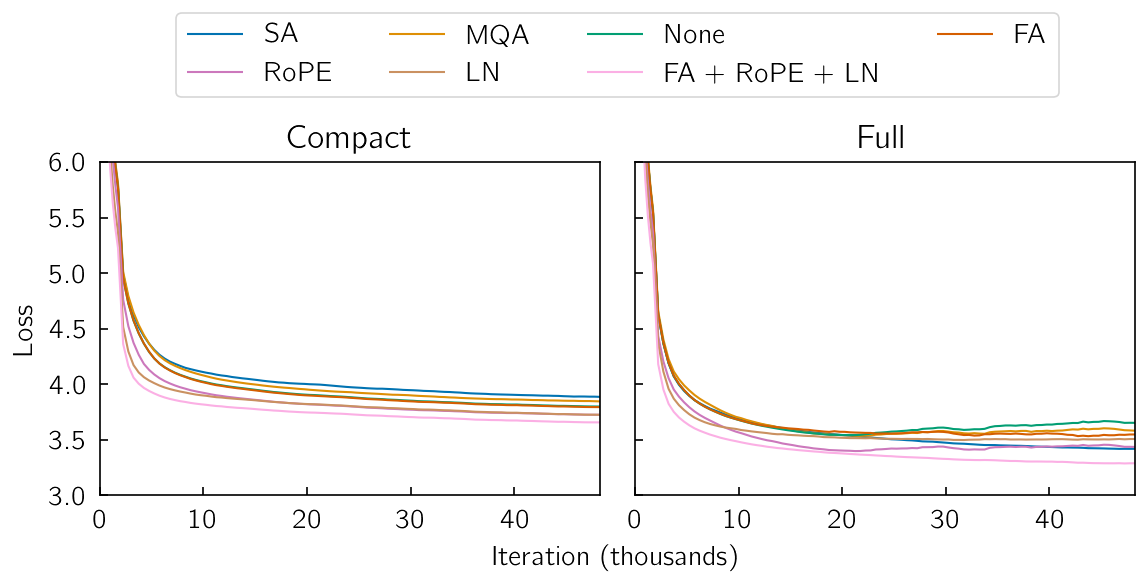

In [33]:
fig, axes = plt.subplots(ncols=2, refaspect=1.5, refwidth=2.5)
steps = full_val_losses['Step']
i = 0
for name, losses in compact_val_losses.items():
    if name == 'Step':
        continue
    axes[0].plot(np.array(steps) * 0.5, losses, label=labels[i], cycle='colorblind10')
    i += 1
i = 0
for name, losses in full_val_losses.items():
    if name == 'Step':
        continue
    axes[1].plot(np.array(steps) * 0.5, losses, cycle='colorblind10')
    i += 1

fig.legend(loc='t', ncols=4)
fig.format(xlabel=r"Iteration (thousands)", ylabel="Loss", ylim=[3, 6])
axes[0].format(title='Compact')
axes[1].format(title='Full')
fig.savefig("loss_curves.pdf", bbox_inches='tight')

## Compute FLOP usage

### Compact Scale

In [34]:
def compact_ceg(minimum: bool = False):
    algo_name_stems_ordered = [
        'compact - sparse_attn',
        'compact - mqa',
        'compact - no_features',
        'compact - flash_attn',
        'compact - rope',
        'compact - layer_norm',
        'compact - flash_attn + rope + layer_norm'
    ]

    labels = [name.replace('compact - ', '') for name in algo_name_stems_ordered]

    baseline_algo_name_stem = 'compact - no_features'
    baseline_loss_key = baseline_algo_name_stem + ' - val/loss'

    if minimum:
        final_baseline_loss_target = min(compact_val_losses[baseline_loss_key])
    else:
        final_baseline_loss_target = compact_val_losses[baseline_loss_key][-1]

    iteration_pass = []
    for name_stem in algo_name_stems_ordered:
        loss_key = name_stem + ' - val/loss'
        losses = np.array(compact_val_losses[loss_key])
        mask = losses <= final_baseline_loss_target
        if np.any(mask):
            iteration_pass.append(np.argmax(mask))
        else:
            iteration_pass.append(None)

    idx_baseline_in_stems = -1
    for i, stem in enumerate(algo_name_stems_ordered):
        if stem == baseline_algo_name_stem:
            idx_baseline_in_stems = i
            break

    it_val_for_baseline = iteration_pass[idx_baseline_in_stems]
    num_steps_baseline_to_target = it_val_for_baseline + 1
    baseline_steps_for_primary_ceg_target = num_steps_baseline_to_target


    for idx, it_val in enumerate(iteration_pass):
        label_current_algo = labels[idx]
        current_algo_name_stem = algo_name_stems_ordered[idx]

        print(f"{label_current_algo}:")
        
        target_loss_display = f"{final_baseline_loss_target:.4f}"

        if it_val is None:
            current_algo_loss_key = current_algo_name_stem + ' - val/loss'
            current_algo_losses = np.array(compact_val_losses[current_algo_loss_key])
            
            min_loss_current_algo = np.min(current_algo_losses)
            steps_to_min_loss_current_algo = np.argmin(current_algo_losses) + 1
            cost_current_algo_to_its_min_loss_aux = steps_to_min_loss_current_algo
                
            print(f"  Primary Target ({target_loss_display}): DNR. Algo's best loss: {min_loss_current_algo:.4f} ({cost_current_algo_to_its_min_loss_aux} steps).")
                
            baseline_losses_arr = np.array(compact_val_losses[baseline_loss_key])
            baseline_mask_for_aux_target = baseline_losses_arr <= min_loss_current_algo

            if np.any(baseline_mask_for_aux_target):
                baseline_steps_to_aux_target = np.argmax(baseline_mask_for_aux_target) + 1
                cost_baseline_to_aux_target_aux = baseline_steps_to_aux_target
                
                if cost_current_algo_to_its_min_loss_aux > 0:
                    aux_ceg = cost_baseline_to_aux_target_aux / cost_current_algo_to_its_min_loss_aux
                    print(f"  Aux CEG (target {min_loss_current_algo:.4f}, steps only): {aux_ceg:.3f}")
                else:
                    print(f"  Aux CEG: Cannot compute (algo steps to its min loss is zero).")
            else:
                min_baseline_loss_overall = np.min(baseline_losses_arr)
                if min_loss_current_algo < min_baseline_loss_overall:
                    print(f"  Aux CEG: Baseline never achieved {min_loss_current_algo:.4f} (algo's best loss is superior to baseline's best: {min_baseline_loss_overall:.4f}).")
                else:
                    print(f"  Aux CEG: Baseline always better than {min_loss_current_algo:.4f} (baseline's best: {min_baseline_loss_overall:.4f}).")
        else:
            num_steps_algo_primary = it_val + 1 
            algo_cost_primary_target = num_steps_algo_primary
            
            if baseline_steps_for_primary_ceg_target > 0 and algo_cost_primary_target > 0 :
                gain = baseline_steps_for_primary_ceg_target / algo_cost_primary_target
                print(f"  Primary CEG (target {target_loss_display}, steps only): {gain:.3f}")
            else:
                print(f"  Primary CEG (target {target_loss_display}, steps only): Cannot compute (non-positive steps).")
                

In [35]:
compact_ceg(minimum = False)

sparse_attn:
  Primary Target (3.7996): DNR. Algo's best loss: 3.8866 (101 steps).
  Aux CEG (target 3.8866, steps only): 0.515
mqa:
  Primary Target (3.7996): DNR. Algo's best loss: 3.8460 (101 steps).
  Aux CEG (target 3.8460, steps only): 0.673
no_features:
  Primary CEG (target 3.7996, steps only): 1.000
flash_attn:
  Primary CEG (target 3.7996, steps only): 1.063
rope:
  Primary CEG (target 3.7996, steps only): 1.870
layer_norm:
  Primary CEG (target 3.7996, steps only): 1.836
flash_attn + rope + layer_norm:
  Primary CEG (target 3.7996, steps only): 3.483


### Full Scale

In [36]:
def full_ceg(minimum: bool = False):
    algo_name_stems_ordered = [
        'full - sparse_attn',
        'full - mqa',
        'full - no_features',
        'full - flash_attn',
        'full - rope',
        'full - layer_norm',
        'full - flash_attn + rope + layer_norm'
    ]

    labels = [name.replace('full - ', '') for name in algo_name_stems_ordered]

    baseline_algo_name_stem = 'full - no_features'
    baseline_loss_key = baseline_algo_name_stem + ' - val/loss'

    if minimum:
        final_baseline_loss_target = min(full_val_losses[baseline_loss_key])
    else:
        final_baseline_loss_target = full_val_losses[baseline_loss_key][-1]

    iteration_pass = []
    for name_stem in algo_name_stems_ordered:
        loss_key = name_stem + ' - val/loss'
        losses = np.array(full_val_losses[loss_key])
        mask = losses <= final_baseline_loss_target
        if np.any(mask):
            iteration_pass.append(np.argmax(mask))
        else:
            iteration_pass.append(None)

    idx_baseline_in_stems = -1
    for i, stem in enumerate(algo_name_stems_ordered):
        if stem == baseline_algo_name_stem:
            idx_baseline_in_stems = i
            break

    it_val_for_baseline = iteration_pass[idx_baseline_in_stems]
    num_steps_baseline_to_target = it_val_for_baseline + 1
    baseline_steps_for_primary_ceg_target = num_steps_baseline_to_target


    for idx, it_val in enumerate(iteration_pass):
        label_current_algo = labels[idx]
        current_algo_name_stem = algo_name_stems_ordered[idx]

        print(f"{label_current_algo}:")
        
        target_loss_display = f"{final_baseline_loss_target:.4f}"

        if it_val is None:
            current_algo_loss_key = current_algo_name_stem + ' - val/loss'
            current_algo_losses = np.array(full_val_losses[current_algo_loss_key])
            
            min_loss_current_algo = np.min(current_algo_losses)
            steps_to_min_loss_current_algo = np.argmin(current_algo_losses) + 1
            cost_current_algo_to_its_min_loss_aux = steps_to_min_loss_current_algo
                
            print(f"  Primary Target ({target_loss_display}): DNR. Algo's best loss: {min_loss_current_algo:.4f} ({cost_current_algo_to_its_min_loss_aux} steps).")
                
            baseline_losses_arr = np.array(full_val_losses[baseline_loss_key])
            baseline_mask_for_aux_target = baseline_losses_arr <= min_loss_current_algo

            if np.any(baseline_mask_for_aux_target):
                baseline_steps_to_aux_target = np.argmax(baseline_mask_for_aux_target) + 1
                cost_baseline_to_aux_target_aux = baseline_steps_to_aux_target
                
                if cost_current_algo_to_its_min_loss_aux > 0:
                    aux_ceg = cost_baseline_to_aux_target_aux / cost_current_algo_to_its_min_loss_aux
                    print(f"  Aux CEG (target {min_loss_current_algo:.4f}, steps only): {aux_ceg:.3f}")
                else:
                    print(f"  Aux CEG: Cannot compute (algo steps to its min loss is zero).")
            else:
                min_baseline_loss_overall = np.min(baseline_losses_arr)
                if min_loss_current_algo < min_baseline_loss_overall:
                    print(f"  Aux CEG: Baseline never achieved {min_loss_current_algo:.4f} (algo's best loss is superior to baseline's best: {min_baseline_loss_overall:.4f}).")
                else:
                    print(f"  Aux CEG: Baseline always better than {min_loss_current_algo:.4f} (baseline's best: {min_baseline_loss_overall:.4f}).")
        else:
            num_steps_algo_primary = it_val + 1 
            algo_cost_primary_target = num_steps_algo_primary
            
            if baseline_steps_for_primary_ceg_target > 0 and algo_cost_primary_target > 0 :
                gain = baseline_steps_for_primary_ceg_target / algo_cost_primary_target
                print(f"  Primary CEG (target {target_loss_display}, steps only): {gain:.3f}")
            else:
                print(f"  Primary CEG (target {target_loss_display}, steps only): Cannot compute (non-positive steps).")

In [37]:
full_ceg(minimum = False)

sparse_attn:
  Primary CEG (target 3.6527, steps only): 0.964
mqa:
  Primary CEG (target 3.6527, steps only): 0.931
no_features:
  Primary CEG (target 3.6527, steps only): 1.000
flash_attn:
  Primary CEG (target 3.6527, steps only): 1.000
rope:
  Primary CEG (target 3.6527, steps only): 1.350
layer_norm:
  Primary CEG (target 3.6527, steps only): 1.421
flash_attn + rope + layer_norm:
  Primary CEG (target 3.6527, steps only): 1.800


In [38]:
def print_min_validation_losses(data_dict, model_type_name):
    print(f"\n--- Minimum Validation Losses for {model_type_name} ---")
    if not data_dict:
        print(f"  No data available for {model_type_name}.")
        return
    for key, loss_values in data_dict.items():
        numeric_losses = np.array(loss_values, dtype=float)
        if np.all(np.isnan(numeric_losses)):
            print(f"  {key}: All values are NaN.")
        else:
            min_loss = np.nanmin(numeric_losses)
            print(f"  {key}: {min_loss:.4f}")

print_min_validation_losses(compact_val_losses, "Compact Models")
print_min_validation_losses(full_val_losses, "Full Models")


--- Minimum Validation Losses for Compact Models ---
  Step: 0.0000
  compact - sparse_attn - val/loss: 3.8866
  compact - mqa - val/loss: 3.8460
  compact - no_features - val/loss: 3.7996
  compact - flash_attn - val/loss: 3.7943
  compact - rope - val/loss: 3.7253
  compact - layer_norm - val/loss: 3.7254
  compact - flash_attn + rope + layer_norm - val/loss: 3.6569

--- Minimum Validation Losses for Full Models ---
  Step: 0.0000
  full - sparse_attn - val/loss: 3.4185
  full - mqa - val/loss: 3.5355
  full - no_features - val/loss: 3.5428
  full - flash_attn - val/loss: 3.5327
  full - rope - val/loss: 3.3988
  full - layer_norm - val/loss: 3.4983
  full - flash_attn + rope + layer_norm - val/loss: 3.2873
